# NLP in Deep Learning
Task 1: CBOW model

Based on https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/5_word2vec.ipynb

Sergei Volodin, sergei.volodin@phystech.edu

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the CBOW model

In [32]:
data_index = 0

def to_range(n):
    return(n % len(data))

# MODIFICATION: batch: array of words, label: one word (central)
# generate batch_size (context, target) pairs with context_size
def generate_batch(batch_size, context_size):
  global data_index
  
  data_index = to_range(data_index)
    
  batch = np.ndarray(shape=(batch_size, context_size * 2), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
  for i in range(batch_size):
    labels[i] = data[data_index]
    for j in range(0, context_size):
      batch[i][2 * j] = data[to_range(data_index - (j + 1))]
      batch[i][2 * j + 1] = data[to_range(data_index + (j + 1))]
    data_index = to_range(data_index + 1)
        
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])
for context_size in [1, 2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, context_size = context_size)
    print('\nwith context_size = %d:' % (context_size))
    print(batch, labels)
    for i in range(8):
        print("batch: ", [reverse_dictionary[bi] for bi in batch[i]], "label: ", [reverse_dictionary[bi] for bi in [labels.reshape(8)[i]]])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
[[  73 3084]
 [5239   12]
 [3084    6]
 [  12  195]
 [   6    2]
 [ 195 3137]
 [   2   46]
 [3137   59]] [[5239]
 [3084]
 [  12]
 [   6]
 [ 195]
 [   2]
 [3137]
 [  46]]

with context_size = 1:
batch:  ['b', 'originated'] label:  ['anarchism']
batch:  ['anarchism', 'as'] label:  ['originated']
batch:  ['originated', 'a'] label:  ['as']
batch:  ['as', 'term'] label:  ['a']
batch:  ['a', 'of'] label:  ['term']
batch:  ['term', 'abuse'] label:  ['of']
batch:  ['of', 'first'] label:  ['abuse']
batch:  ['abuse', 'used'] label:  ['first']
[[  73 3084   16   12]
 [5239   12   73    6]
 [3084    6 5239  195]
 [  12  195 3084    2]
 [   6    2   12 3137]
 [ 195 3137    6   46]
 [   2   46  195   59]
 [3137   59    2  156]] [[5239]
 [3084]
 [  12]
 [   6]
 [ 195]
 [   2]
 [3137]
 [  46]]

with context_size = 2:
batch:  ['b', 'originated', 'five', 'as'] label:  ['anarchism']
batch:  ['anarchism', 'as', 'b', 'a'] label:  

In [46]:
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
context_size = 2
num_sampled = 64
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, context_size * 2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
    
  # MODIFICATION: use reduce_mean (sum of embeddings for all input words)
  embed = tf.reduce_mean(tf.nn.embedding_lookup(embeddings, train_dataset), [1])
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Training CBOW model

In [47]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, context_size)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.071195
Nearest to was: regimental, fortified, cliffordadams, proliferation, appraisal, traumas, aristophanes, cited,
Nearest to eight: smitten, aloe, mummified, erectus, password, tedious, duckburg, fantastically,
Nearest to not: odp, cro, ats, annan, anyone, albinus, amalthea, tp,
Nearest to UNK: liturgy, w, detectors, serbia, gondwana, sancho, conferring, dissenting,
Nearest to his: moulds, pleasuredome, distrust, parchment, lapland, ample, incomplete, dorians,
Nearest to an: concord, demme, cjd, satsuki, tc, barbarism, elias, quoting,
Nearest to may: telegraphic, dresden, varela, academy, academia, landis, novell, reservists,
Nearest to by: mites, orchids, koenig, rafe, kettle, nomen, loud, camelopardalis,
Nearest to zero: conceal, yemen, overman, dogma, dmoz, mystic, reaffirmed, servo,
Nearest to has: surrounds, discontinued, indices, excavation, londoners, libation, drama, dungeon,
Nearest to d: excommunication, pioneered, lining, fundamental,

In [48]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

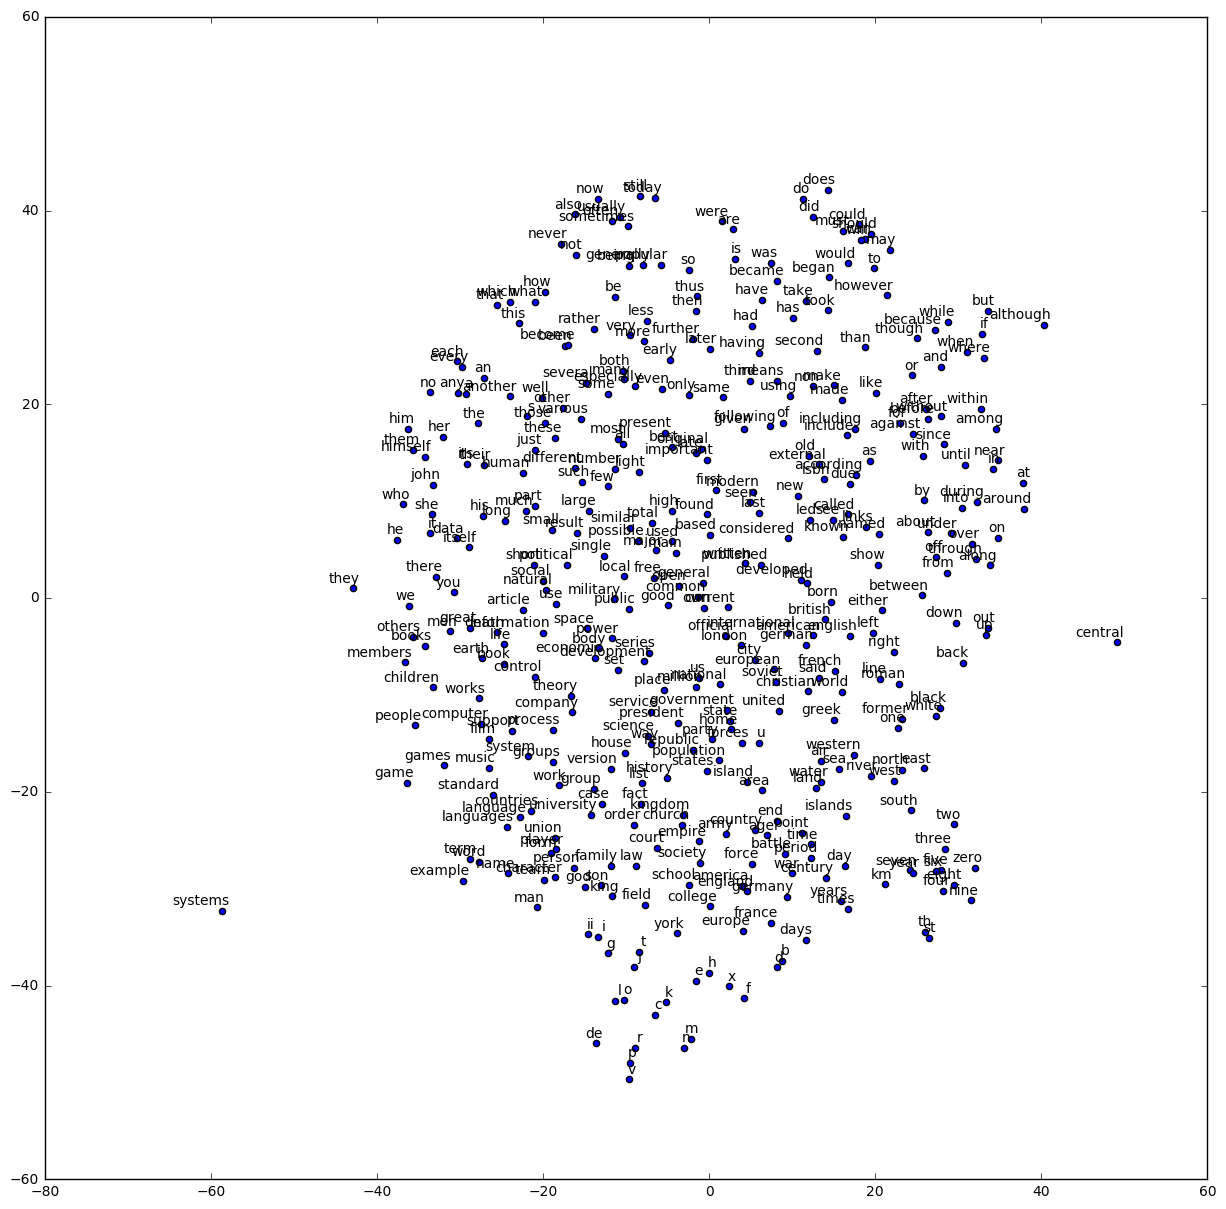

In [49]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)